_This notebook was put together by [Keneth Garcia](https://stivengarcia7113.wixsite.com/kenethgarcia). Source and license info are on [GitHub](https://github.com/KenethGarcia/ClassiPyGRB)._

# t-Distributed Stochastic Neighbor Embedding (t-SNE) Overview in Swift/BAT data

The Neil Gehrels Swift Observatory presents analysis results for the Swift/BAT Gamma-Ray Burst (GRBs) on [this website](https://swift.gsfc.nasa.gov/results/batgrbcat/) (open access).

In previous notebooks, we pre-process Swift Data to apply T-SNE and other dimensionality reduction techniques. In this notebook, we are going to analyze the results obtained in order to classify GRBs. Through this document, we are using the _python3_ implementations from the _ClassiPyGRB_ package. It is necessary to have a _Jupyter Notebook_/_Python 3_ compiler software.

First, we need to import the _SWIFT_ instance of _ClassiPyGRB_ to our notebook (and some other packages needed):

In [12]:
from ClassiPyGRB import SWIFT
# Packages needed for this notebook
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

At this point, we need to load the data from the _SWIFT_ instance of _ClassiPyGRB_:

In [2]:
swift = SWIFT(root_path=r'type-your-path-here', res=64, n_bands=[1, 2, 3, 4, 5])
print(f"Swift/BAT bands selected: {swift.bands_selected}")

Swift/BAT bands selected: ['Time(s)', '15-25keV', '25-50keV', '50-100keV', '100-350keV', '15-350keV']


Now, from the [Preprocessing notebook](https://github.com/KenethGarcia/ClassiPyGRB/blob/20d417a5fa93f2a48ec1e5cb913484e87b05c339/docs/3.BAT_Preprocess.ipynb), extract the GRB Names, pre-processed data and index the GRB duration $T_{90}$:

In [3]:
data_loaded = np.load(os.path.join(swift.results_path, f'SWIFT_data_{swift.res}res_{"".join(str(b) for b in swift.n_bands)}bands_DFT_True.npz'))
names_64ms, features_64ms = data_loaded['names'], data_loaded['data']
durations_64ms = swift.total_durations(names_64ms, t=90)

Finding Durations: 100%|██████████| 1451/1451 [00:00<00:00, 1545.49GRB/s]


If you have not pre-process data yet, check the [Preprocessing notebook](https://github.com/KenethGarcia/ClassiPyGRB/blob/20d417a5fa93f2a48ec1e5cb913484e87b05c339/docs/3.BAT_Preprocess.ipynb).

# GRB classification

This notebook summarizes the findings and effort to find correlations and identify similarities for GRBs through the clustering visualization of the t-SNE technique. These results follow [Garcia-Cifuentes et al.(2023)](https://arxiv.org/abs/2304.08666). Moreover, you can see other relevant works as [Jespersen et al.(2020)](https://iopscience.iop.org/article/10.3847/2041-8213/ab964d) or [Steinhardt et al.(2023)](https://iopscience.iop.org/article/10.3847/1538-4357/acb999) to further understand the topic.

As [Jespersen et al.(2020)](https://iopscience.iop.org/article/10.3847/2041-8213/ab964d) demonstrated, the t-SNE technique is a powerful tool to classify GRBs. By using this unsupervised technique, it is possible to discern about a correlation between the position of the GRB in the t-SNE space and its duration.

[Garcia-Cifuentes et al.(2023)](https://arxiv.org/abs/2304.08666) and [Steinhardt et al.(2023)](https://iopscience.iop.org/article/10.3847/1538-4357/acb999) demonstrated that this correlation is preserved at least for Swift/BAT data in 2023. Let's see how this correlation looks like making a TSNE embedding using perplexity values of 5 and 30:

In [4]:
%%time
pos_64ms = [swift.perform_tsne(features_64ms, perplexity=pp, learning_rate=200) for pp in [5, 30]]

CPU times: user 3min 57s, sys: 39.8 s, total: 4min 37s
Wall time: 58.3 s


Plotting the results:

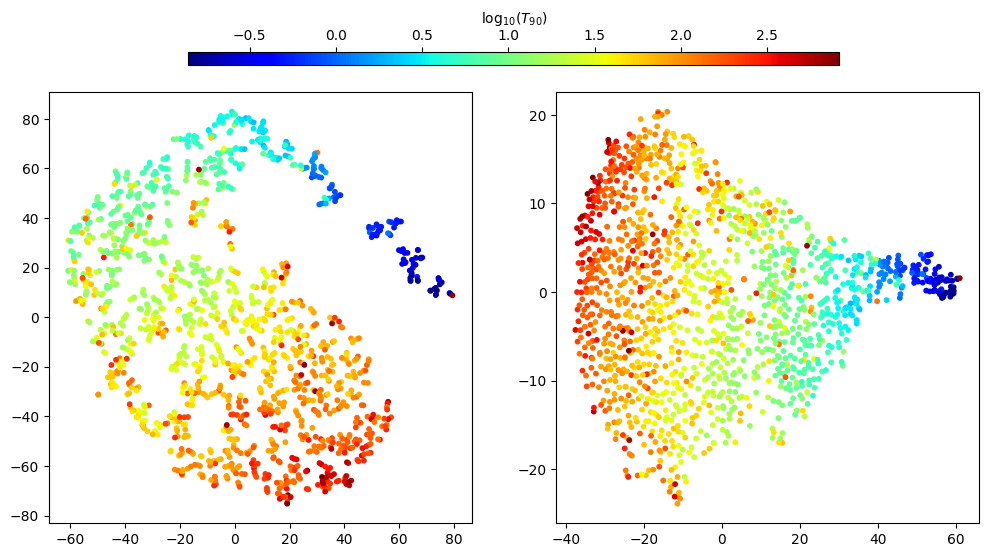

In [5]:
fig = plt.figure(figsize=(12, 7))
gs = fig.add_gridspec(ncols=2, nrows=1, wspace=0.2, hspace=0.2)
ax = gs.subplots()
for i, pos in enumerate(pos_64ms):
    ax[i], bar = swift.plot_tsne(pos, durations_64ms, ax=ax[i], return_colorbar=True, marker_size=10)
    bar.remove() if bar != () else None
    plt.axis('on')
# Add a shared color bar:
norm = mpl.colors.Normalize(vmin=min(np.log10(durations_64ms)), vmax=max(np.log10(durations_64ms)))
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.jet), ax=ax[:], location='top', label=r'log$_{10}\left(T_{90}\right)$', shrink=0.7, aspect=50)

Although it is less evident in the case with $perplexity=30$ (right panel of the figure), the GRBs are divided into two groups with a different range of $T_{90}$.

In this way, it is possible to classify GRBs into two groups: short GRBs (SGRBs) and long GRBs (LGRBs). To make this classification, you can use the `split_points` instance of **ClassiPyGRB**. By using this function, it is possible to extract the names of GRBs in each group by using two approaches:

1. Separating groups by using a (x,y) limits: You can divide the plot in 4 quadrants using a horizontal line at $y$ and a vertical line at $x$, then you can specify which quadrant you need to use to separate groups.
2. Using a line passing in two points $(x_1, y_1)$ and $(x_2, y_2)$: A more general approach is divide the entire plot by using a line separating the two subgroups, you need to pass $(x_1, x_2)$ as `x_s` and $(y_1, y_2)$ as `y_s`.

In this case, we are going to use the first option:

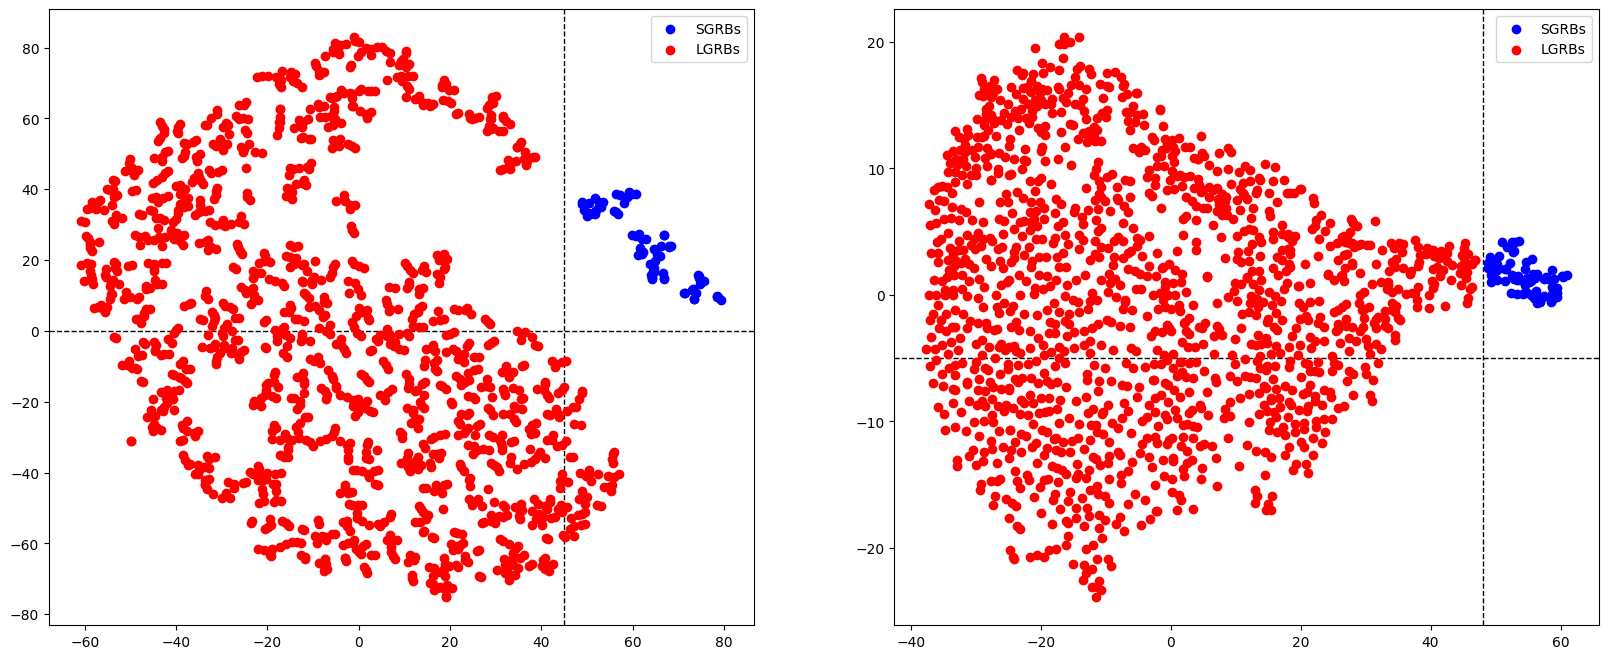

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# First case
group1, group2 = swift.split_points(pos_64ms[0], x_s=45, y_s=0, quadrant=1)  # Split points in quadrant 1 of x=50 and y=0 divisions
ax[0].axvline(x=45, c='k', ls='--', linewidth=1)
ax[0].axhline(y=0, c='k', ls='--', linewidth=1)
ax[0].scatter(group1[:, 0], group1[:, 1], c='b', label='SGRBs', zorder=10)
ax[0].scatter(group2[:, 0], group2[:, 1], c='r', label='LGRBs', zorder=10)
ax[0].legend()

# Second case
group3, group4 = swift.split_points(pos_64ms[1], x_s=48, y_s=-5)  # Split points in quadrant 1 of x=45 and y=0 divisions
ax[1].axvline(x=48, c='k', ls='--', linewidth=1)
ax[1].axhline(y=-5, c='k', ls='--', linewidth=1)
ax[1].scatter(group3[:, 0], group3[:, 1], c='b', label='SGRBs', zorder=10)
ax[1].scatter(group4[:, 0], group4[:, 1], c='r', label='LGRBs', zorder=10)
ax[1].legend()

As you can see, these function works great to divide the GRBs into two groups. Now, it is time to show the distribution of duration and hardness_ratio for each group.

## Duration distribution

In order to compare with previous results, we created the `duration_histogram` function to replicate the histograms of durations from other facilities such as BATSE and Fermi/GBM. This function takes the names of GRBs in each group as unique mandatory argument, and optionally can receive the durations' interval, the colours of each group in the histogram and additional kwargs of the `matplotlib.axes.Axes.hist` function:

Finding Durations: 100%|██████████| 1380/1380 [00:01<00:00, 1152.81GRB/s]


Text(0, 0.5, 'Number of GRBs')

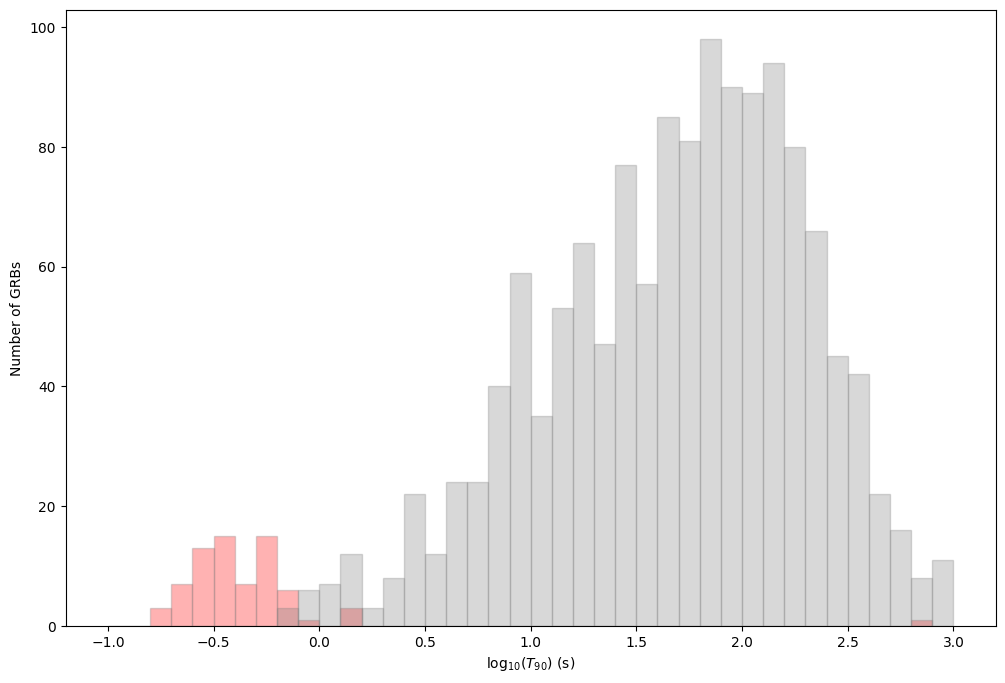

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
match = np.unique(np.where(np.isin(pos_64ms[0], group1))[0])
match2 = np.unique(np.where(np.isin(pos_64ms[0], group2))[0])
names1 = names_64ms[match]
names2 = names_64ms[match2]
swift.duration_histogram(names=[names1, names2], alpha=0.3, color_groups=['r', 'gray'], ax=ax)
ax.set_xlabel(r'log$_{10}(T_{90})$ (s)')
ax.set_ylabel('Number of GRBs')

As you can see, the distribution of $T_{90}$ is different for each group. On this notebook, there are 71 SGRBs and 1380 LGRBs classified by using the t-SNE technique. These groups are the same in the case of $perplexity=5$ and $perplexity=30$.

Here, we highlight that t-SNE only needs the Fourier Spectrum of each one of the light curves of Swift/BAT. As result, this tools is able to classify GRBs in two groups with different duration distributions without using any other information or human prior knowledge.

## Hardness ratio distribution

To estimate the hardness ratio, **ClassiPyGRB** uses a proxy based on the ratio of the flux in $50-100$ keV and $25-50$ keV bands ([Jespersen et al. 2020](https://iopscience.iop.org/article/10.3847/2041-8213/ab964d)).

To find the flux in both bands, **ClassiPyGRB** uses the `swift.get_flux` function, which takes the name of the GRB as unique mandatory argument, and optionally can receive the energy band (`band`) and if you want to calculate the flux between some limits (`t` and `limits`, same args as `lc_limiter` instance). Consider the following example:

In [8]:
example = 'GRB060614'
flux = swift.get_flux(example, band=3, t=None, limits=[-1, 100])
print(f'Flux in 50-100 keV band: {flux:.3}')

Flux in 50-100 keV band: 7.12


On the other hand, to get the hardness ratio, you can use the `hardness_ratio` instance of `SWIFT`, which takes the name or names of GRBs as unique mandatory argument. The same example as before:

In [9]:
hardness = swift.hardness_ratio(example)
print(f'Hardness ratio: {hardness:.3}')

Hardness ratio: 0.547


Now, let's see the distribution of hardness ratio for each group. To do this, we use the `hardness_ratio` instance over all short and long GRBs and plot the density map:

In [19]:
short_durations = swift.total_durations(names1, t=90)
short_hardness = swift.hardness_ratio(names1)
df_short = pd.DataFrame({'name': names1, 'T_90': short_durations, 'logT_90':np.log10(short_durations), 'hardness': short_hardness})
print(df_short.round(3))

Finding Durations: 100%|██████████| 71/71 [00:00<00:00, 1103.90GRB/s]


          name   T_90  logT_90  hardness
0    GRB050813  0.384   -0.416     0.743
1    GRB060801  0.504   -0.298     1.577
2    GRB061217  0.224   -0.650     1.558
3    GRB070406  0.816   -0.088     0.829
4   GRB070429B  0.488   -0.312     0.720
..         ...    ...      ...       ...
66  GRB201221D  0.164   -0.785     0.826
67  GRB210323A  1.120    0.049     0.737
68  GRB210726A  0.384   -0.416     0.849
69  GRB210919A  0.164   -0.785     0.859
70  GRB220412B  0.140   -0.854     0.806

[71 rows x 4 columns]


In [25]:
long_durations = swift.total_durations(names2, t=90)
long_hardness = swift.hardness_ratio(names2)
df_long = pd.DataFrame({'Name': names2, 'T_90': long_durations, 'logT_90': np.log10(long_durations), 'hardness': long_hardness})

Finding Durations: 100%|██████████| 1380/1380 [00:01<00:00, 1080.55GRB/s]


Text(0, 0.5, '$s(50-100)/s(25-50)$')

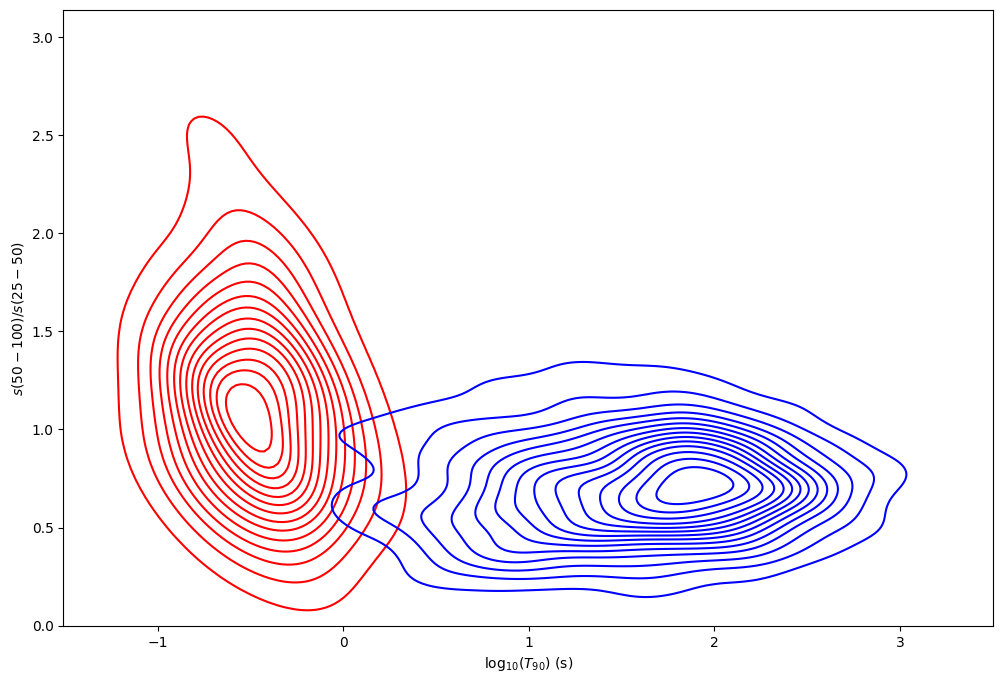

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.kdeplot(data=df_short, y='hardness', x='logT_90', ax=ax, levels=15, color="red")
sns.kdeplot(data=df_long, y='hardness', x='logT_90', ax=ax, levels=15, color='blue')
ax.set_ylim(bottom=0)
ax.set_xlabel(r'log$_{10}(T_{90})$ (s)')
ax.set_ylabel(r'$s(50-100)/s(25-50)$')

The distribution of hardness ratio seems very similar to the Figure 8 of [Steinhardt et al.(2023)](https://iopscience.iop.org/article/10.3847/1538-4357/acb999).  t-SNE is able to separate bursts with similar bulk properties, replicating a very well known result: the group of long GRBs are softer and longer than short GRBs, with some overlapping in the middle of the plot.

Finally, the evidence presented through this notebook shows that the groups isolated by this technique are not merely a coincidence or a pipeline or spurious result, but a real separation of GRBs with different properties.